In [1]:
!mkdir brain_tumor_githubCommands



In [ ]:
!pip install imagehash
!pip install --upgrade tensorflow



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import shutil
from skimage.metrics import structural_similarity as ssim
from PIL import Image
from tqdm import tqdm
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image
import imagehash
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from sklearn.model_selection import train_test_split


In [ ]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:


# Download latest version
path = kagglehub.dataset_download("pkdarabi/medical-image-dataset-brain-tumor-detection")

print("Path to dataset files:", path)

In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5"
print(os.listdir(dataset_path))


In [ ]:
!cp -r /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5 /content/dataset


✅ Found 9192 images.


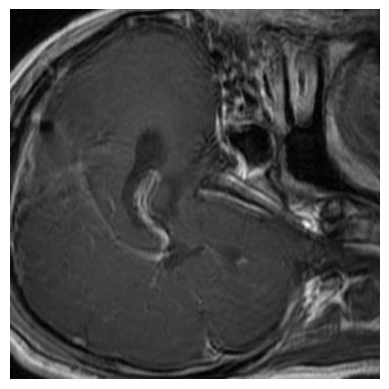

In [ ]:
import os


# Base dataset path
dataset_path = "/content/dataset/BrainTumor"

# Correct folder names
yolo_versions = ["BrainTumorYolov8", "BrainTumorYolov9", "BrainTumorYolov11"]
subdirs = ["train/images", "test/images", "valid/images"]

# Collect all image files
image_files = []
for yolo_version in yolo_versions:
    for subdir in subdirs:
        img_dir = os.path.join(dataset_path, yolo_version, subdir)
        if os.path.exists(img_dir):  # Ensure folder exists
            for file in os.listdir(img_dir):
                if file.lower().endswith((".jpg", ".png", ".jpeg", ".tif", ".bmp")):
                    image_files.append(os.path.join(img_dir, file))

# Show results
if len(image_files) == 0:
    print("❌ No images found! Check folder structure.")
else:
    print(f"✅ Found {len(image_files)} images.")

    # Open the first image to verify
if len(image_files) > 0:
    img = Image.open(image_files[0])  # Open the first image
    plt.imshow(img)  # Display the image
    plt.axis("off")  # Hide axis
    plt.show()  # Show image in Colab
else:
    print("❌ No images found to display.")




In [ ]:
!pip install scikit-image imagehash


In [ ]:
import os
import numpy as np
import shutil
import imagehash  # ✅ Importing imagehash
from skimage.metrics import structural_similarity as ssim
from PIL import Image
from tqdm import tqdm
from collections import defaultdict  # ✅ Importing defaultdict

# Function to compute perceptual hash (PHash)
def get_phash(image_path, size=(200, 200)):
    try:
        img = Image.open(image_path).convert("L").resize(size)  # Convert to grayscale + resize
        return str(imagehash.phash(img))  # Convert PHash to string
    except:
        return None  # Return None if error occurs

# Function to preprocess an image for SSIM
def preprocess_image(image_path, size=(200, 200)):
    img = Image.open(image_path).convert("L").resize(size)  # Convert to grayscale and resize
    return np.array(img)  # Convert to NumPy array

# Function to remove duplicate images using PHash + SSIM
def remove_duplicates(image_files, phash_threshold=5, ssim_threshold=0.95):
    phash_dict = defaultdict(list)  # ✅ Initialize defaultdict here
    duplicates = set()

    # Step 1: Compute PHash for each image
    print("🔍 Computing PHash for images...")
    for img_path in tqdm(image_files):
        phash = get_phash(img_path)
        if phash is not None:
            phash_dict[phash[:4]].append((phash, img_path))  # Group by first 4 digits of PHash

    # Step 2: Compare images within PHash groups using SSIM
    print("🔍 Running SSIM on similar PHash images...")
    for phash_group in tqdm(list(phash_dict.values())):
        total_images = len(phash_group)
        for i in range(total_images):
            if phash_group[i][1] in duplicates:
                continue

            img1 = preprocess_image(phash_group[i][1])

            for j in range(i + 1, total_images):
                if phash_group[j][1] in duplicates:
                    continue

                # Compare PHash distance first
                if abs(int(phash_group[i][0], 16) - int(phash_group[j][0], 16)) > phash_threshold:
                    continue  # Skip if PHash is too different

                # If PHash is similar, run SSIM
                img2 = preprocess_image(phash_group[j][1])
                score = ssim(img1, img2)

                if score >= ssim_threshold:
                    duplicates.add(phash_group[j][1])

    return duplicates

# Step 3: Collect all image paths
image_files = []
dataset_path = "/content/dataset/BrainTumor"
yolo_versions = ["BrainTumorYolov8", "BrainTumorYolov9", "BrainTumorYolov11"]
subdirs = ["train/images", "test/images", "valid/images"]

for yolo_version in yolo_versions:
    for subdir in subdirs:
        img_dir = os.path.join(dataset_path, yolo_version, subdir)
        if os.path.exists(img_dir):
            for file in os.listdir(img_dir):
                if file.lower().endswith((".jpg", ".png", ".jpeg", ".tif", ".bmp")):
                    image_files.append(os.path.join(img_dir, file))

# Step 4: Run optimized duplicate detection
print(f"🔍 Checking {len(image_files)} images for duplicates...")
duplicates = remove_duplicates(image_files)

# Step 5: Delete duplicate images
for duplicate in duplicates:
    os.remove(duplicate)

print(f"✅ Removed {len(duplicates)} duplicate images.")


🔍 Checking 9192 images for duplicates...
🔍 Computing PHash for images...


100%|██████████| 9192/9192 [00:51<00:00, 178.78it/s]


🔍 Running SSIM on similar PHash images...


100%|██████████| 2212/2212 [01:05<00:00, 33.85it/s]


✅ Removed 6128 duplicate images.


In [ ]:
dataset_path = "/content/dataset/BrainTumor"
print("YOLO versions inside dataset:", os.listdir(dataset_path))


YOLO versions inside dataset: ['BrainTumorYolov9', 'BrainTumorYolov11', 'BrainTumorYolov8']


In [ ]:
image_dir = "/content/dataset/BrainTumor/BrainTumorYolov8/train/images"
print("Images in train set:", os.listdir(image_dir)[:10])  # Show first 10 images


Images in train set: ['2970_jpg.rf.c4f1673a4811df79e3deb5438a679fa0.jpg', '3046_jpg.rf.5d033541834887c6690f1ec5e0549731.jpg', '70_jpg.rf.2b80ce2dedf361f33f172d35f7f5bbd1.jpg', '354_jpg.rf.11769a7fd8c3cd0c0665b4c4f5f2c6c3.jpg', '260_jpg.rf.bc5b2f28d7fe66b2036ac0780fa4635c.jpg', '136_jpg.rf.ccd445ba62e2d624ec6e0f1751b56a4c.jpg', '2214_jpg.rf.5b34cd848dc7bf2401c14a65a7b9e860.jpg', '472_jpg.rf.71a4c2c37feedbc3686428e39855a55f.jpg', '2499_jpg.rf.def32fa61982e8ef2fe2c6b3f5cf9b4a.jpg', '467_jpg.rf.f94b0013f280e12d215baecc8c0aa3fe.jpg']


In [ ]:
print(os.listdir("/content/dataset"))

['BrainTumor']


In [ ]:
!find /content -type d -name "*cleaned*"  # Look for folders with 'cleaned' in the name


In [ ]:

dataset_path = "/content/dataset/BrainTumor/BrainTumorYolov11"
print("Train images:", len(os.listdir(os.path.join(dataset_path, "train/images"))))
print("Test images:", len(os.listdir(os.path.join(dataset_path, "test/images"))))
print("Valid images:", len(os.listdir(os.path.join(dataset_path, "valid/images"))))


Train images: 0
Test images: 0
Valid images: 0


In [ ]:
import os

dataset_path = "/content/dataset/BrainTumor"

for yolo_version in ["BrainTumorYolov8", "BrainTumorYolov9", "BrainTumorYolov11"]:
    for subset in ["train/images", "test/images", "valid/images"]:
        folder_path = os.path.join(dataset_path, yolo_version, subset)
        if os.path.exists(folder_path):
            print(f"{yolo_version} - {subset}: {len(os.listdir(folder_path))} images")
        else:
            print(f"{yolo_version} - {subset} does NOT exist!")


BrainTumorYolov8 - train/images: 2144 images
BrainTumorYolov8 - test/images: 308 images
BrainTumorYolov8 - valid/images: 612 images
BrainTumorYolov9 - train/images: 0 images
BrainTumorYolov9 - test/images: 0 images
BrainTumorYolov9 - valid/images: 0 images
BrainTumorYolov11 - train/images: 0 images
BrainTumorYolov11 - test/images: 0 images
BrainTumorYolov11 - valid/images: 0 images


In [ ]:
dataset_path = "/content/dataset/BrainTumor/BrainTumorYolov8"


In [ ]:
for subset in ["train/labels", "test/labels", "valid/labels"]:
    folder_path = os.path.join(dataset_path, subset)
    if os.path.exists(folder_path):
        print(f"{subset}: {len(os.listdir(folder_path))} label files")
    else:
        print(f"{subset} does NOT exist!")

train/labels: 2144 label files
test/labels: 308 label files
valid/labels: 612 label files


In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
dataset_path = "/content/dataset/BrainTumor/BrainTumorYolov8"
image_size = (224, 224)  # Resize images to 224x224 for Xception

# Classes for classification
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]
num_classes = len(classes)

# Function to load images and labels
def load_data(images_folder, labels_folder):
    images = []
    labels = []

    for file in os.listdir(images_folder):
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(images_folder, file)
            label_path = os.path.join(labels_folder, file.rsplit('.', 1)[0] + ".txt")  # Handles different extensions

            # Read and preprocess image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img) / 255.0  # Normalize pixels (0-1)
            images.append(img)

            # Read label file
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label_data = f.readline().strip()
                    label_index = int(label_data.split()[0])  # Assuming class index is first value
                    labels.append(label_index)
            else:
                print(f"⚠️ Missing label for {file}")
                labels.append(-1)  # Assign unknown class

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Remove images with missing labels (-1)
    valid_indices = labels != -1
    return images[valid_indices], labels[valid_indices]

# Load train, test, and valid data
X_train, y_train = load_data(
    os.path.join(dataset_path, "train/images"),
    os.path.join(dataset_path, "train/labels")
)
X_test, y_test = load_data(
    os.path.join(dataset_path, "test/images"),
    os.path.join(dataset_path, "test/labels")
)
X_valid, y_valid = load_data(
    os.path.join(dataset_path, "valid/images"),
    os.path.join(dataset_path, "valid/labels")
)

# Ensure labels are valid (not -1) before encoding
y_train = y_train[y_train >= 0]
y_test = y_test[y_test >= 0]
y_valid = y_valid[y_valid >= 0]

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_valid = to_categorical(y_valid, num_classes)

print(f"✅ Loaded dataset: Train={X_train.shape}, Test={X_test.shape}, Valid={X_valid.shape}")


✅ Loaded dataset: Train=(2144, 224, 224, 3), Test=(308, 224, 224, 3), Valid=(612, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout , BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Load Xception model (without top layers)
xception_base = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# New code Added
for layer in xception_base.layers[:100]:
    layer.trainable = False
# till here

xception_features = GlobalAveragePooling2D()(xception_base.output)
xception_features = Dropout(0.5)(xception_features)ry folder you create using !mkdir is located und

# Define PDCNN layers (Custom implementation based on research paper)
pdcnn_input = Input(shape=(224, 224, 3), name="pdcnn_input")
pdcnn_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(pdcnn_input)

pdcnn_layer = BatchNormalization(momentum=0.9, epsilon=1e-5)(pdcnn_layer)
# pdcnn_layer = tf.keras.layers.ReLU()(pdcnn_layer) # use Only if not using activation in Conv2D
pdcnn_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(pdcnn_layer)
pdcnn_layer = BatchNormalization(momentum=0.9, epsilon=1e-5)(pdcnn_layer)
# pdcnn_layer = tf.keras.layers.ReLU()(pdcnn_layer) # use Only if not using activation in Conv2D

  # pdcnn_layer = Flatten()(pdcnn_layer)
  # pdcnn_layer = Dropout(0.6)(pdcnn_layer)
pdcnn_layer = GlobalAveragePooling2D()(pdcnn_layer)
pdcnn_layer = Dropout(0.5)(pdcnn_layer)

# Concatenate both models
merged = Concatenate()([xception_features, pdcnn_layer])
output_layer = Dense(num_classes, activation="softmax", kernel_regularizer=l2(0.001))(merged) # try using kernel_regularizer=l2(0.001)

# Build final model
model = Model(inputs=[xception_base.input, pdcnn_input], outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7)



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,889,708 (79.69 MB)

 Trainable params: 9,506,380 (36.26 MB)

 Non-trainable params: 11,383,328 (43.42 MB)

In [ ]:
# Train the model
#from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
# model.fit(train_data, validation_data=val_data, epochs=15, callbacks=[early_stopping])

# creating train and test for Xception and PDCNN

X_train_xception = X_train  # Xception expects (224, 224, 3) images
X_valid_xception = X_valid
X_test_xception = X_test

X_train_pdcnn = X_train  # PDCNN also expects (224, 224, 3) images
X_valid_pdcnn = X_valid
X_test_pdcnn = X_test

##
history = model.fit(
    [X_train_xception, X_train_pdcnn], y_train,  # Separate inputs for Xception & PDCNN
    validation_data=([X_valid_xception, X_valid_pdcnn], y_valid),
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    batch_size=16
)


# Evaluate the model
test_loss, test_acc = model.evaluate([X_test, X_test], y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")


Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 225ms/step - accuracy: 0.3903 - loss: 1.3167 - val_accuracy: 0.6536 - val_loss: 0.8758 - learning_rate: 1.0000e-05
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 55s 150ms/step - accuracy: 0.7530 - loss: 0.8913 - val_accuracy: 0.8268 - val_loss: 0.5332 - learning_rate: 1.0000e-05
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.8332 - loss: 0.5758 - val_accuracy: 0.8791 - val_loss: 0.3960 - learning_rate: 1.0000e-05
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.8621 - loss: 0.4296 - val_accuracy: 0.8971 - val_loss: 0.3337 - learning_rate: 1.0000e-05
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.8910 - loss: 0.3577 - val_accuracy: 0.9020 - val_loss: 0.3005 - learning_rate: 1.0000e-05
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9212 - loss: 0.2830 - val_accuracy: 0.9101 - val_loss: 0.2611 - learning_rate: 1.0000e-05
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.9548 - loss: 0.1781
🧪 Test Accuracy: 0.9481


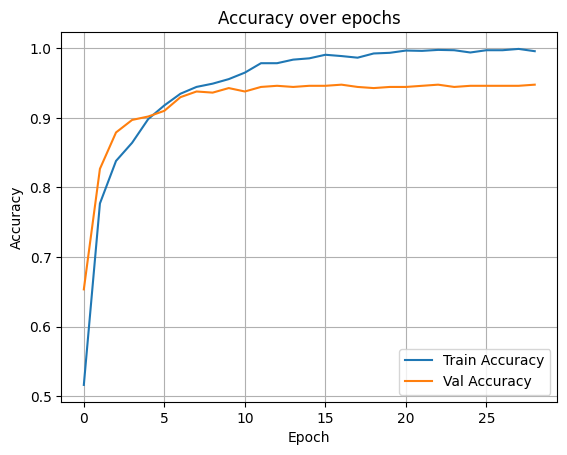

In [ ]:
loss, acc = model.evaluate([X_test, X_test], y_test)
print(f"🧪 Test Accuracy: {acc:.4f}")
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


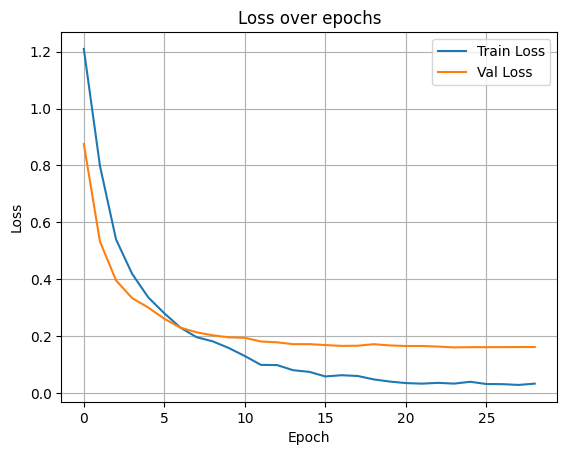

In [ ]:

# Plot loss too
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# 1. Get predictions
y_pred_probs = model.predict([X_test, X_test])  # or [X_test_xcep, X_test_pdcnn]
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro'
print(f"🎯 Weighted F1 Score: {f1:.4f}")

# 3. Full Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 528ms/step
🎯 Weighted F1 Score: 0.9487

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9682    0.9560    0.9620       159
           1     0.8485    0.9032    0.8750        62
           2     0.9882    0.9655    0.9767        87

    accuracy                         0.9481       308
   macro avg     0.9350    0.9416    0.9379       308
weighted avg     0.9497    0.9481    0.9487       308



In [ ]:
# Save the trained model
model.save("/content/xception_pdcnn_model.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
import os

model_path = "/content/xception_pdcnn_model.h5"

if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully!")
else:
    print(f"❌ Model file not found at: {model_path}. Please train and save the model first.")


✅ Model loaded successfully!


In [ ]:
# Load the trained model
model = tf.keras.models.load_model("/content/xception_pdcnn_model.h5")
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [ ]:
test_loss, test_acc = model.evaluate([X_test, X_test], y_test)
print(f"✅ Model Accuracy after loading: {test_acc:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.9548 - loss: 0.1781
✅ Model Accuracy after loading: 0.9481


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the class labels
class_labels = ["Glioma", "Meningioma", "Pituitary", "No Tumor"]

# Load the trained model
model = tf.keras.models.load_model("/content/xception_pdcnn_model.h5")  # Update path if needed

# Function to predict tumor type from an image
def predict_tumor(image_path):
    image_size = (224, 224)  # Match model input size

    # Load and preprocess image
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img) / 255.0  # Normalize (0-1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Model expects 2 inputs, so duplicate the image
    input_xception = img  # First input (for Xception)
    input_pdcnn = img  # Second input (for PDCNN)


    # Get prediction (PASS BOTH INPUTS)
    prediction = model.predict([input_xception, input_pdcnn])  # ✅ Fixed input format

    predicted_class = np.argmax(prediction)  # Get class index
    confidence = np.max(prediction) * 100  # Get confidence score

    print(f"🔍 Prediction: {class_labels[predicted_class]} ({confidence:.2f}%)")
    return class_labels[predicted_class], confidence


In [ ]:

test_image_path = "/content/BrainTumorTestImage.jpg"  # Update with your image path
predict_tumor(test_image_path)


In [ ]:
test_image_path = "/content/BrainTumorTestImageGlioma.jpg"  # Update with your image path
predict_tumor(test_image_path)

In [ ]:
import pickle

# Saving the model using Pickle
model_dict = {
    'model': model,
    'architecture': model.to_json(),  # Save the model architecture as JSON
}

with open("brain_tumor_Hybrid_model.pkl", "wb") as f:
    pickle.dump(model_dict, f)


In [ ]:
from google.colab import files
files.download("brain_tumor_Hybrid_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
from tensorflow.keras.models import model_from_json

# Load the Pickle file
with open("brain_tumor_Hybrid_model.pkl", "rb") as f:
    model_dict = pickle.load(f)

# Load the model architecture from JSON
model = model_from_json(model_dict['architecture'])

# Load the model weights (assuming you saved weights earlier or separately)
model.load_weights('path_to_your_model_weights.h5')

# Now, the model is ready for use!


In [ ]:
model.save("brain_tumor_Hybrid_model.h5")

In [ ]:
from google.colab import files
files.download("brain_tumor_Hybrid_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("brain_tumor_Hybrid_model.h5")
